**Лабораторная работа 2**


In [ ]:
!pip install memory_profiler

  Created wheel for memory-profiler: filename=memory_profiler-0.60.0-py3-none-any.whl size=31284 sha256=ac054686e8cbc76fe591a6643ed76082e64ac1542c7b31825b73d169b20e92da
  Stored in directory: /root/.cache/pip/wheels/67/2b/fb/326e30d638c538e69a5eb0aa47f4223d979f502bbdb403950f
Successfully built memory-profiler


In [ ]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from math import e
from matplotlib.colors import ListedColormap
from datetime import datetime
from scipy.linalg import cho_factor, cho_solve
from numpy.linalg import norm
from scipy.optimize import minimize
from scipy.optimize._minimize import _minimize_powell
from scipy.optimize.optimize import _linesearch_powell, wrap_function
from memory_profiler import memory_usage
from abc import ABC, ABCMeta, abstractmethod
import dataclasses
from typing import List
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

In [ ]:
np.random.seed(42) # set seed of random

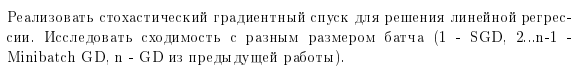

In [ ]:
def calc_diff(w, x, y):
    return 2 * (np.dot(w, x) - y) * x

def calc_error(w, x, y):
    return (np.dot(w, x) - y)**2

def validate(w, X, Y):
  err = 0
  for i in range(len(X) - 1):
    err = err + calc_error(w, X[i], Y[i])
  return err / len(X)

def predict(w, x):
    return np.dot(w, x)

In [ ]:
def SGD(minibatch_size, num_iters, optimizer, X, Y):
    n = len(X)
    w = np.zeros(len(X[0])) # assume that last elem in w is b
    for i in range(num_iters):
      perm = np.random.permutation(n)
      k = 0
      while k < n:
        grad = np.zeros(len(X[0]))
        for j in range(min(minibatch_size, n - k - 1)):
          idx = perm[k + j]
          grad = grad + calc_diff(w, X[idx], Y[idx])
        w = w - 0.0001 * grad
        k = k + minibatch_size
    return w

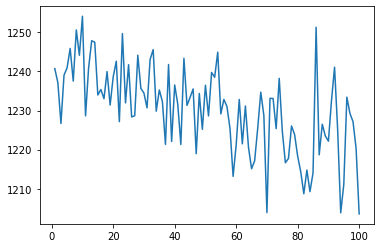

In [ ]:
num_features = 10
num_samples = 100
X, Y = make_regression(n_samples=num_samples, n_features=num_features)

new_X = []
for x in X:
  arr = [1]
  for elem in x:
      arr.append(elem)
  new_X.append(np.array(arr))

X = new_X

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#build plot
x = []
y = []
for i in range(num_samples):
  w = SGD(i + 1, 100, None, X_train, Y_train)
  x.append(i+1)
  y.append(validate(w, X_test, Y_test))

plt.plot(x, y)
plt.show()

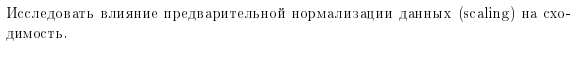

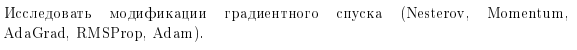


In [ ]:
class AbstractModification:
    __metaclass__ = ABCMeta

    @abstractmethod
    def step(self, lr: float, grad, w_i): raise NotImplementedError

class NoModification(AbstractModification):
    def step(self, lr: float, grad, w_i):
        return lr * grad(w_i)


class Nesterov(AbstractModification):
    alpha: float # примерно 0.9
    prev_g: float

    def __init__(self, alpha: float):
        self.alpha = alpha
        self.prev_g = 0

    def step(self, lr: float, grad, w_i):
        self.prev_g = lr * grad(w_i - self.alpha * self.prev_g) + self.alpha * self.prev_g
        return self.prev_g 

class Momentum(AbstractModification):
    alpha: float # примерно 0.9
    prev_g: float

    def __init__(self, alpha: float):
        self.alpha = alpha
        self.prev_g = 0

    def step(self, lr: float, grad, w_i):
        self.prev_g = lr * grad(w_i) + self.alpha * self.prev_g
        return self.prev_g 

class Adagrad(AbstractModification):
    lr_0: float # примерно 0.9
    
    eps = 1e-8

    def __init__(self, lr_0: float, G_helper):
        self.lr_0 = lr_0
        self.G_helper = G_helper

    def calculate_rate(self, grad_i):
      self.G_helper = [self.G_helper[j] + (grad_i[j])**2 for j in range(len(self.G_helper))]
      return [self.lr_0 / (self.G_helper[i] + self.eps) ** 0.5 for i in range(len(self.G_helper))]

# grad[0][0] ... grad[0][n]
# ...
# grad[p][0] ... grad[p][n]
# G[p][i] = grad[j][i]**2 for j in range(p)

    def step(self, lr: float, grad, w_i):
        curr_grad = grad(w_i)
        rate = self.calculate_rate(curr_grad)
        return  curr_grad * rate # поэлементное произведение

In [ ]:
def SGD_with_mods(minibatch_size, num_iters, lr, mod: AbstractModification, X, Y):
    n = len(X)
    ws = []
    trace = []
    w = np.zeros(len(X[0])) # assume that last elem in w is b
    for i in range(num_iters):
      perm = np.random.permutation(n)
      k = 0
      if i % 10 == 0:
        trace.append([X[perm[0]], Y[perm[0]]])
      def calc_grad(w):
        grad = np.zeros(len(X[0]))
        for j in range(min(minibatch_size, n - k - 1)):
          idx = perm[k + j]
          grad = grad + calc_diff(w, X[idx], Y[idx])
        return grad
      while k < n:
        w = w - mod.step(lr, calc_grad, w)
        k += minibatch_size
      if i % 10 == 0:
        ws.append(w)
    return w, ws, trace

In [ ]:
num_features = 100
num_samples = 100
tmp, Y = make_regression(n_samples=num_samples, n_features=num_features)

X = []
for x in tmp:
  arr = [1]
  for elem in x:
      arr.append(elem)
  X.append(np.array(arr))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

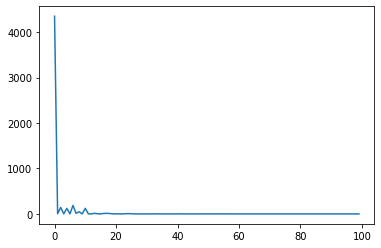

In [ ]:
#Default Stochastic descent
w, ws, trace = SGD_with_mods(50, 1000, 0.001, NoModification(), X_train, Y_train)
y = [(trace[i][1] - predict(ws[i], trace[i][0])) ** 2 for i in range(len(trace))]
x = [i for i in range(len(trace))]
plt.plot(x, y)
plt.show()

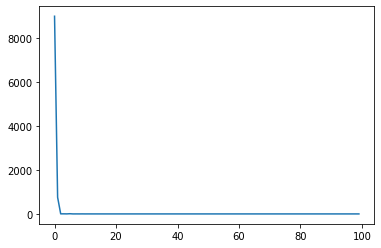

In [ ]:
#Stochastic descent with Momentum modification
w, ws, trace = SGD_with_mods(50, 1000, 0.001, Momentum(0.8), X_train, Y_train)
y = [(trace[i][1] - predict(ws[i], trace[i][0])) ** 2 for i in range(len(trace))]
x = [i for i in range(len(trace))]
plt.plot(x, y)
plt.show()

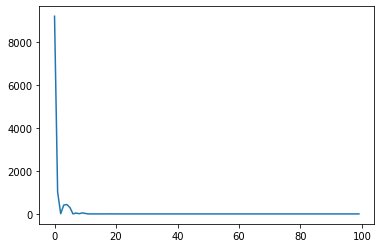

In [ ]:
#Stochastic descent with Nesterov modification
w, ws, trace = SGD_with_mods(50, 1000, 0.001, Nesterov(0.99), X_train, Y_train)
y = [(trace[i][1] - predict(ws[i], trace[i][0])) ** 2 for i in range(len(trace))]
x = [i for i in range(len(trace))]
plt.plot(x, y)
plt.show()

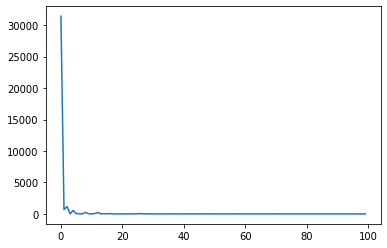

In [ ]:
#Stochastic descent with Adagrad modification
w, ws, trace = SGD_with_mods(50, 1000, 0.001, Adagrad(7, np.zeros(len(X[0]))), X_train, Y_train)
y = [(trace[i][1] - predict(ws[i], trace[i][0])) ** 2 for i in range(len(ws))]
x = [i for i in range(len(ws))]

plt.plot(x, y)
plt.show()

In [ ]:
# class Statistics():
#   def __init__(self):
#     self.error: float = 0.0
#     self.grad_call_count: int = 0
#     self.time_sec: float = datetime.now()
#     self.memory_mb: float = memory_usage()[0]
  
#   def print(self, minibatch_size):
#     print("-------------------------===-------------------------")
#     print()
#     print("Minibatch size ", minibatch_size)
#     print("Error ", self.error)
#     print(f"Time: {self.time_sec} sec")
#     print(f"Memory usage: {self.memory_mb} MB")
#     print("Gradient calls: ", self.grad_call_count)

# def SGD_stat(minibatch_size, num_iters, optimizer, X, Y):
#     statistics = Statistics()
#     n = len(X)
#     w = np.zeros(len(X[0])) # assume that last elem in w is b
#     for i in range(num_iters):
#       perm = np.random.permutation(n)
#       grad = np.zeros(len(X[0]))
#       for j in range(minibatch_size):
#         idx = perm[j % n]
#         statistics.grad_call_count += 1
#         grad = grad + calc_diff(w, X[idx], Y[idx])
#       w = w - 0.0001 * grad

#     statistics.time_sec = (datetime.now() - statistics.time_sec).total_seconds()
#     statistics.memory_mb = memory_usage()[0] - statistics.memory_mb
    
#     return w, statistics

# X_train_norm, X_test_norm, Y_train_norm, Y_test_norm = train_test_split(X, Y, test_size=0.2, random_state=42)

# x_norm = []
# y_norm = []
# for i in range(1, 1001, 100):
#   w, statistics = SGD_stat(i, 100, None, X_train_norm, Y_train_norm)
#   statistics.error = validate(w, X_test_norm, Y_test_norm)
#   statistics.print(i)

In [ ]:
import time

class Statistics():
  def __init__(self):
    self.error: float = 0.0
    self.grad_call_count: int = 0
    self.time_sec: float = 0
    self.memory_mb: float = memory_usage()[0]
  
  def print(self, minibatch_size, algo):
    print("-------------------------===-------------------------")
    print()
    print(f"Algo: ", type(algo).__name__)
    print("Minibatch size ", minibatch_size)
    print("Error ", self.error)
    print(f"Time: {self.time_sec} sec")
    print("Gradient calls: ", self.grad_call_count)

def SGD_with_mods_and_stat(minibatch_size, num_iters, lr, mod: AbstractModification, X, Y):
    statistics = Statistics()
    start = time.time()
    n = len(X)
    ws = []
    trace = []
    w = np.zeros(len(X[0])) # assume that last elem in w is b
    for i in range(num_iters):
      perm = np.random.permutation(n)
      k = 0
      if i % 10 == 0:
        trace.append([X[perm[0]], Y[perm[0]]])
      def calc_grad(w):
        grad = np.zeros(len(X[0]))
        for j in range(min(minibatch_size, n - k - 1)):
          idx = perm[k + j]
          statistics.grad_call_count += 1
          grad = grad + calc_diff(w, X[idx], Y[idx])
        return grad
      while k < n:
        w = w - mod.step(lr, calc_grad, w)
        k += minibatch_size
      if i % 10 == 0:
        ws.append(w)

    statistics.grad_call_count += minibatch_size * num_iters
    statistics.time_sec = time.time() - start

    return w, ws, trace, statistics


X_train_norm, X_test_norm, Y_train_norm, Y_test_norm = train_test_split(X, Y, test_size=0.2, random_state=42)

x_norm = []
y_norm = []
algos = [NoModification(), Momentum(0.8), Nesterov(0.99)]

for i in range(1, 101, 10):
  for algo in algos:
    w, ws, trace, statistics = SGD_with_mods_and_stat(i, 1000, 0.001, algo, X_train, Y_train)
    statistics.error = validate(w, X_test_norm, Y_test_norm)
    statistics.print(i, algo)

  


-------------------------===-------------------------

Algo:  NoModification
Minibatch size  1
Error  4658.540854301797
Time: 2.133721351623535 sec
Gradient calls:  80000
-------------------------===-------------------------

Algo:  Momentum
Minibatch size  1
Error  4650.3900903965705
Time: 2.4570088386535645 sec
Gradient calls:  80000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in multiply
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in add


-------------------------===-------------------------

Algo:  Nesterov
Minibatch size  1
Error  nan
Time: 2.740218162536621 sec
Gradient calls:  80000
-------------------------===-------------------------

Algo:  NoModification
Minibatch size  11
Error  4658.804388582773
Time: 0.5019948482513428 sec
Gradient calls:  90000
-------------------------===-------------------------

Algo:  Momentum
Minibatch size  11
Error  4650.390090085513
Time: 0.5117878913879395 sec
Gradient calls:  90000
-------------------------===-------------------------

Algo:  Nesterov
Minibatch size  11
Error  nan
Time: 0.5389068126678467 sec
Gradient calls:  90000
-------------------------===-------------------------

Algo:  NoModification
Minibatch size  21
Error  4659.29350610359
Time: 0.45734381675720215 sec
Gradient calls:  100000
-------------------------===-------------------------

Algo:  Momentum
Minibatch size  21
Error  4650.39008796129
Time: 0.476240873336792 sec
Gradient calls:  100000
----------------